# Litteraturbanken Author 
version 1.1 

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      Open question how to see [JSON 23](https://github.com/spraakbanken/littb-frontend/issues/23)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)

**The objective** Find all Litteraturbanken Author objects that has Show True and have a WIkidata oibject for that item

**Lesson learned**
1. we need to filter in Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text 
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning
3. we have a big number of Authors not matched to Wikidata abr 790 authors that we should try to match or create new records in Wikidata


## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]  
### 2) copyright on metadata?
We need CC0 to import data in Wikidata (see [Wikidata:Licensing](https://www.wikidata.org/wiki/Wikidata:Licensing)) e.g. if we should add all books as objects in Wikidata with no text and create links to Litteraturbanken then fields like below need to be [CC-0](https://creativecommons.org/share-your-work/public-domain/cc0/)  
* Författare
* Verk
* Libris-id 
* förlaga	
* eid	
* Införd	
* Länk i klartext	
* Epub	
* Källa

In [1]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2020-10-01 00:59:19.871746


In [2]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [3]:
df.head()

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
0,AarneA,AarneA,"{'date': '1867', 'plain': '1867'}",d4646f71d18e1304e4b16a557dd2f8cf,1600563813743,"{'date': '1925', 'plain': '1925'}",author,Antti Aarne,male,2014-02-11,None,0xbfm5hj2hjvvwn,"Aarne, Antti",None,False,False,Aarne,2019-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AasenE,AasenE,"{'date': '1935', 'plain': '1935'}",f9d8d6666830bbe11a5153518eb5ca7b,1600563813501,NaN,author,Elisabeth Aasen,female,2014-03-13,None,53hlsf1p1mc2mpw,"Aasen, Elisabeth",None,False,True,Aasen,2019-10-16,"{'birthplace': None, 'birthplace_label': None,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AbeniusM,AbeniusM,"{'date': '1899', 'plain': '1899'}",3f54cad107a4eabdbe746046f109a593,1600563813504,{'plain': '1970'},author,Margit Abenius,female,2017-04-14,\n<p>MARGIT ABENIUS (1899–1970): ”Margit Abeni...,ljx00mt45v0dfx5,"Abenius, Margit",None,True,True,Abenius,2019-10-16,"{'birthplace': [14.628893758, 61.090146823], '...",1.600608e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AbrahamssonG,AbrahamssonG,"{'date': '1961', 'plain': '1961'}",3d398cb6d33ac0cb9f1f0bc26d6eb9bf,1600563813515,NaN,author,Gunnel Abrahamsson,female,2014-02-11,None,NaN,"Abrahamsson, Gunnel",None,False,False,Abrahamsson,2014-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AbrahamssonS,AbrahamssonS,"{'date': '1872', 'plain': '1872'}",4f3cceeb16912e0524fd79011dafbf7f,1600563813518,"{'date': '1911', 'plain': '1911'}",author,Selma Abrahamsson,female,2018-10-25,None,NaN,"Abrahamsson, Selma",None,False,True,Abrahamsson,2018-10-25,NaN,1.600608e+12,{'intro': ' <p>SELMA ABRAHAMSSON (1872–1911) ...,722.0,"[{'authorid': 'Flavia_pseudonym', 'authorid_no...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#df.info() 
df[df['authorid'].str.contains("SchotteniusM")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
2872,SchotteniusM,SchotteniusM,"{'date': '1953', 'plain': '1953'}",02995c6ee296c72d0eb57500429443a7,1600563816296,NaN,author,Maria Schottenius,female,2014-03-17,None,khwz0rc33phfqrp,"Schottenius, Maria",None,False,True,Schottenius,2019-10-16,"{'birthplace': None, 'birthplace_label': None,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    wd = row['wikidata']
    try:            
        new_item['wd'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['authorid','wd','authorid_norm','show'])
LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   authorid       3656 non-null   object
 1   wd             1418 non-null   object
 2   authorid_norm  3656 non-null   object
 3   show           3656 non-null   bool  
dtypes: bool(1), object(3)
memory usage: 89.4+ KB


In [6]:
LitteraturbankenTot["authorid"].value_counts()

ÄhrlingE          1
HörnströmM        1
SondénPA          1
JonssonT          1
MannheimerO       1
                 ..
MøllerJ           1
UndhagenCG        1
LarssonI          1
MarnersdóttirM    1
MyrénV            1
Name: authorid, Length: 3656, dtype: int64

In [7]:
LitteraturbankenTot["show"].value_counts()

True     2288
False    1368
Name: show, dtype: int64

In [8]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 
LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 1 to 3655
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   authorid       2288 non-null   object
 1   wd             1318 non-null   object
 2   authorid_norm  2288 non-null   object
 3   show           2288 non-null   bool  
dtypes: bool(1), object(3)
memory usage: 73.7+ KB


In [9]:
LitteraturbankenTotShow

,authorid,wd,authorid_norm,show
1,AasenE,Q11967131,AasenE,True
2,AbeniusM,Q4933592,AbeniusM,True
4,AbrahamssonS,NaN,AbrahamssonS,True
5,AchariusE,Q365923,AchariusE,True
6,AckeJAG,NaN,AckeJAG,True
...,...,...,...,...
3644,ÖhmanA,Q6256668,OhmanA,True
3645,OhmanFA,NaN,OhmanFA,True
3647,ÖnnerforsA,NaN,OnnerforsA,True
3653,ÖstinO,NaN,OstinO,True


In [10]:
df[df['authorid'].str.contains("AbeniusM")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
2,AbeniusM,AbeniusM,"{'date': '1899', 'plain': '1899'}",3f54cad107a4eabdbe746046f109a593,1600563813504,{'plain': '1970'},author,Margit Abenius,female,2017-04-14,\n<p>MARGIT ABENIUS (1899–1970): ”Margit Abeni...,ljx00mt45v0dfx5,"Abenius, Margit",None,True,True,Abenius,2019-10-16,"{'birthplace': [14.628893758, 61.090146823], '...",1.600608e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Wikidata

In [11]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [12]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  1604 non-null   object
 1   authorid    1604 non-null   object
dtypes: object(2)
memory usage: 25.2+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [13]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    0
authorid      0
dtype: int64

### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas
2. **Litterturbanken_only** skall skapas/matchas i Wikidata
 

In [14]:
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)

In [15]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["_merge"].value_counts()  

both          1586
right_only     703
left_only       18
Name: _merge, dtype: int64

In [16]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)

dfmerge[0:10]  

,WikidataID,authorid,wd,authorid_norm,show,WD_Litteraturbanken
0,Q11967131,AasenE,Q11967131,AasenE,True,both
1,Q4933592,AbeniusM,Q4933592,AbeniusM,True,both
2,Q4934135,AbrahamssonS,NaN,AbrahamssonS,True,both
3,Q365923,AchariusE,Q365923,AchariusE,True,both
4,Q5541979,AckeJAG,NaN,AckeJAG,True,both
5,Q109244,AdamBremen,Q109244,AdamBremen,True,both
6,Q4933819,AdelborgO,Q4933819,AdelborgO,True,both
7,Q3338577,AdlerbethGJ,Q3338577,AdlerbethGJ,True,both
8,Q918652,AdlersparreG,Q918652,AdlersparreG,True,both
9,Q4346827,AdlersparreS,Q4346827,AdlersparreS,True,both


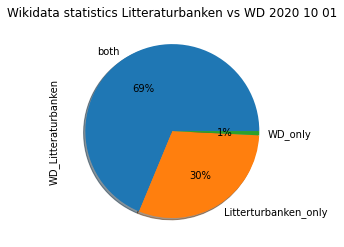

In [17]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [18]:
mergeCheckNumber

both                    1586
Litterturbanken_only     703
WD_only                   18
Name: WD_Litteraturbanken, dtype: int64

In [32]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly

,WikidataID,authorid,wd,authorid_norm,show,WD_Litteraturbanken
98,Q2063496,AstromP,NaN,NaN,NaN,WD_only
266,Q14932468,ButenschonA,NaN,NaN,NaN,WD_only
499,Q71400163,FredenG,NaN,NaN,NaN,WD_only
512,Q98916411,FrodingTorgnyS,NaN,NaN,NaN,WD_only
671,Q4605867,HoijerBE,NaN,NaN,NaN,WD_only
691,Q99751230,HornströmM,NaN,NaN,NaN,WD_only
734,Q3565615,JaunouchK,NaN,NaN,NaN,WD_only
801,Q712630,KotlumJ,NaN,NaN,NaN,WD_only
887,Q98960221,LilljebjornEG,NaN,NaN,NaN,WD_only
937,Q19754121,LovgrenS,NaN,NaN,NaN,WD_only


In [33]:
df[df['authorid_norm'].str.contains("AstromP")] 

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
3634,ÅströmPa,AstromPa,"{'date': '1955', 'plain': '1955'}",d3e0f19b538efde1c823040441f4fdad,1600563813705,{'plain': '0000'},author,Patrik Åström,male,2017-01-02,None,NaN,"Åström, Patrik",None,True,True,Åström,2017-01-16,"{'birthplace': None, 'birthplace_label': None,...",1.600608e+12,NaN,633.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3635,ÅströmP,AstromP,"{'date': '1929', 'plain': '1929'}",4454dd0c11c3d5e865b5950a542f22ba,1600563813703,{'plain': '2008'},author,Paul Åström,male,2014-02-11,None,NaN,"Åström, Paul",None,True,False,Åström,2014-03-17,"{'birthplace': [17.29833333, 62.39113889], 'bi...",1.600608e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and uplöoad the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [20]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid',right_on='authorid_norm')
wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}] 


,WikidataID,authorid_x,authorid_y,show_y


In [21]:
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="both"]  
wddelete.head()

,WikidataID,authorid,wd,authorid_norm,show,WD_Litteraturbanken
0,Q11967131,AasenE,Q11967131,AasenE,True,both
1,Q4933592,AbeniusM,Q4933592,AbeniusM,True,both
2,Q4934135,AbrahamssonS,NaN,AbrahamssonS,True,both
3,Q365923,AchariusE,Q365923,AchariusE,True,both
4,Q5541979,AckeJAG,NaN,AckeJAG,True,both


In [22]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [23]:
dfmerge_authorid_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   WikidataID           1297 non-null   object  
 1   authorid_x           1297 non-null   object  
 2   wd_x                 1075 non-null   object  
 3   authorid_norm_x      1297 non-null   object  
 4   show_x               1297 non-null   object  
 5   WD_Litteraturbanken  1297 non-null   object  
 6   authorid_y           1297 non-null   object  
 7   wd_y                 1075 non-null   object  
 8   authorid_norm_y      1297 non-null   object  
 9   show_y               1297 non-null   bool    
 10  _merge               1297 non-null   category
dtypes: bool(1), category(1), object(9)
memory usage: 104.0+ KB


In [24]:
dfmerge_authorid_norm.head()

,WikidataID,authorid_x,wd_x,authorid_norm_x,show_x,WD_Litteraturbanken,authorid_y,wd_y,authorid_norm_y,show_y,_merge
0,Q11967131,AasenE,Q11967131,AasenE,True,both,AasenE,Q11967131,AasenE,True,both
1,Q4933592,AbeniusM,Q4933592,AbeniusM,True,both,AbeniusM,Q4933592,AbeniusM,True,both
2,Q4934135,AbrahamssonS,NaN,AbrahamssonS,True,both,AbrahamssonS,NaN,AbrahamssonS,True,both
3,Q365923,AchariusE,Q365923,AchariusE,True,both,AchariusE,Q365923,AchariusE,True,both
4,Q5541979,AckeJAG,NaN,AckeJAG,True,both,AckeJAG,NaN,AckeJAG,True,both


In [25]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### FInd objects with Show false at Litteratirbanken 
If found in Wikidata they are candidates to be deleted in Wikidata

In [26]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [27]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

left_only     1604
right_only    1368
both             0
Name: _merge, dtype: int64

In [28]:
dfmergeDelete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2972 entries, 0 to 2971
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   WikidataID     1604 non-null   object  
 1   authorid       2972 non-null   object  
 2   wd             100 non-null    object  
 3   authorid_norm  1368 non-null   object  
 4   show           1368 non-null   object  
 5   _merge         2972 non-null   category
dtypes: category(1), object(5)
memory usage: 142.3+ KB


In [29]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Ended:  2020-10-01 00:59:25.739100
Time elapsed (hh:mm:ss.ms) 0:00:05.869276
